<a href="https://colab.research.google.com/github/Bruna-gc/NeuralNetworksResearch/blob/main/W_Assymetry_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# GPU Setup and Optimization
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import math

#FUNCTIONS

#Functions

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Enable optimizations for better GPU performance
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# Optimized Functions (GPU-accelerated)
def create_patterns(size, num_patterns):
    """Create random bipolar patterns (+1, -1) using PyTorch - GPU optimized"""
    patterns = torch.randint(0, 2, (num_patterns, size), device=device, dtype=torch.float32)
    patterns = 2 * patterns - 1  # Convert 0,1 to -1,1
    return patterns

def train(patterns, N, lambda_):
    """Train network by Hebbian learning - fully PyTorch GPU optimized"""
    # Use optimized matrix multiplication
    weights = torch.mm(patterns.T, patterns)
    # Normalize FIRST, then set diagonal
    weights = weights / N
    weights.fill_diagonal_(lambda_)
    return weights

def asymmetry(weights, delta, asymmetry_type='single', asymmetry_num=1, N_neurons=None):
    """
    Apply asymmetry to weight matrix

    Args:
        weights: Weight matrix to modify
        delta: Asymmetry parameter
        asymmetry_type: 'single', 'pair', 'all', or 'neighbors'
        asymmetry_num: Number of connections to modify (for 'single' and 'pair')
        N_neurons: Number of neurons to modify (for 'neighbors' type)
    """
    W = weights.clone()  # Always clone to preserve original

    if asymmetry_type == 'single':
        # Case 1: Only modify weight[i,j] *= (1+delta) for one connection
        rows, cols = W.shape
        random_rows = torch.randperm(rows, device=device)[:asymmetry_num]
        random_cols = torch.randperm(cols, device=device)[:asymmetry_num]
        # Ensure no diagonal elements
        while torch.any(random_rows == random_cols):
            random_cols = torch.randperm(cols, device=device)[:asymmetry_num]
        for random_row, random_col in zip(random_rows, random_cols):
            W[random_row, random_col] *= (1 + delta)

    elif asymmetry_type == 'pair':
        # Case 2: Modify both weight[i,j] *= (1+delta) and weight[j,i] *= (1-delta)
        rows, cols = W.shape
        random_rows = torch.randperm(rows, device=device)[:asymmetry_num]
        random_cols = torch.randperm(cols, device=device)[:asymmetry_num]

        # Ensure no diagonal elements
        while torch.any(random_rows == random_cols):
            random_cols = torch.randperm(cols, device=device)[:asymmetry_num]
        for random_row, random_col in zip(random_rows, random_cols):
            W[random_row, random_col] *= (1 + delta)
            W[random_col, random_row] *= (1 - delta)

    elif asymmetry_type == 'all':
        # Case 3: All upper triangular *= (1+delta), all lower triangular *= (1-delta)
        upper = torch.triu(W, diagonal=1)
        lower = torch.tril(W, diagonal=-1)
        # matrix with only diagonal to preserve it
        diag = torch.diag(torch.diag(W))
        W = upper*(1 + delta) + lower*(1 - delta) + diag

    elif asymmetry_type == 'neighbors':
        # Case 4: Modify weights for N_neurons consecutive (neighboring) neurons
        if N_neurons is None:
            N_neurons = weights.shape[0] // 4  # Default to 25% of neurons

        rows, cols = W.shape
        # Select a random starting position for consecutive neurons
        start_idx = torch.randint(0, rows - N_neurons + 1, (1,), device=device).item()
        neighbor_indices = torch.arange(start_idx, start_idx + N_neurons, device=device)

        # Create meshgrid for all combinations of neighbor indices
        i_indices, j_indices = torch.meshgrid(neighbor_indices, neighbor_indices, indexing='ij')

        # Flatten the indices
        i_flat = i_indices.flatten()
        j_flat = j_indices.flatten()

        # Remove diagonal elements (i == j)
        non_diagonal = i_flat != j_flat
        i_flat = i_flat[non_diagonal]
        j_flat = j_flat[non_diagonal]

        # Apply asymmetry: upper triangular gets (1+delta), lower gets (1-delta)
        upper_mask = i_flat < j_flat
        lower_mask = i_flat > j_flat

        # Apply modifications
        W[i_flat[upper_mask], j_flat[upper_mask]] *= (1 + delta)
        W[i_flat[lower_mask], j_flat[lower_mask]] *= (1 - delta)

    return W

def create_noisy_input(pattern, num_flips):
    """Create noisy input by flipping random bits - PyTorch GPU optimized"""
    noisy_input = pattern.clone()
    if num_flips > 0:
        indices = torch.randperm(len(pattern), device=device)[:num_flips]
        noisy_input[indices] *= -1
    return noisy_input

def recall(W, input_pattern, steps=5):
    """Recall pattern from noisy input - fully PyTorch GPU optimized"""
    # Handle single pattern input
    if input_pattern.ndim == 1:
        input_pattern = input_pattern.unsqueeze(0)
    patterns = input_pattern.clone()

    for _ in range(steps):
        # Vectorized computation for all patterns at once
        net_input = torch.mm(patterns, W.T)
        # Ensure strictly -1 or 1 (no zeros) - GPU optimized
        patterns = torch.where(net_input >= 0, 1.0, -1.0)
    return patterns.squeeze() if patterns.shape[0] == 1 else patterns

def recovered_patterns(recalled_patterns, patterns):
    """Count recovered patterns - fully PyTorch GPU optimized"""
    # Handle single pattern comparison
    if recalled_patterns.ndim == 1:
        recalled_patterns = recalled_patterns.unsqueeze(0)
    if patterns.ndim == 1:
        patterns = patterns.unsqueeze(0)
    # Vectorized comparison - GPU optimized
    matches = torch.all(recalled_patterns == patterns, dim=1)
    return int(torch.sum(matches).item())

def get_recovered_percent(recalled_patterns, patterns):
    """Get recovery percentage - fully PyTorch GPU optimized"""
    return recovered_patterns(recalled_patterns, patterns) / patterns.shape[0] * 100

def batch_recall_patterns(W, patterns, num_flips, steps=5):
    """Process patterns with a single noise level for better GPU utilization"""
    # Create all noisy inputs at once with the same noise level
    noisy_patterns = []
    for pattern in patterns:
        noisy_pattern = create_noisy_input(pattern, num_flips)
        noisy_patterns.append(noisy_pattern)

    # Stack and process in batch
    noisy_batch = torch.stack(noisy_patterns)
    recalled_batch = recall(W, noisy_batch, steps)

    # Calculate recovery percentage
    recovery_percent = get_recovered_percent(recalled_batch, patterns)
    return recovery_percent

def run_recovery_analysis(delta, asymmetry_type, analysis_name, iterations=10, N=200, max_patterns=100, noise_level=0, N_neurons=None):
    """Run recovery analysis for given asymmetry type - now returns mean and std"""
    # Removed print statement for cleaner output

    # Load values (p/N ratios) - Extended range with finer resolution
    load_values = np.arange(0.05, 1.01, 0.05)  # 5% to 100% load with 5% steps

    # Store results
    recovery_results = []
    recovery_std = []

    for load in load_values:
        num_patterns = max(1, int(load * N))  # Ensure at least 1 pattern

        # Average over multiple iterations
        iteration_results = []

        for iteration in range(iterations):
            # Create patterns
            patterns = create_patterns(N, num_patterns)
            # Train network
            W = train(patterns, N, 0.0)  # lambda = 0 for standard Hopfield
            # Apply asymmetry
            W = asymmetry(W, delta, asymmetry_type, N_neurons=N_neurons)
            # Test with specific noise level
            recovery_percentage = batch_recall_patterns(W, patterns, noise_level)
            iteration_results.append(recovery_percentage)

        # Calculate mean and standard deviation across iterations
        mean_recovery = np.mean(iteration_results)
        std_recovery = np.std(iteration_results)
        recovery_results.append(mean_recovery)
        recovery_std.append(std_recovery)

    return load_values, recovery_results, recovery_std

#GRAPH FUNCTIONS


Total analysis time: 234.75 seconds


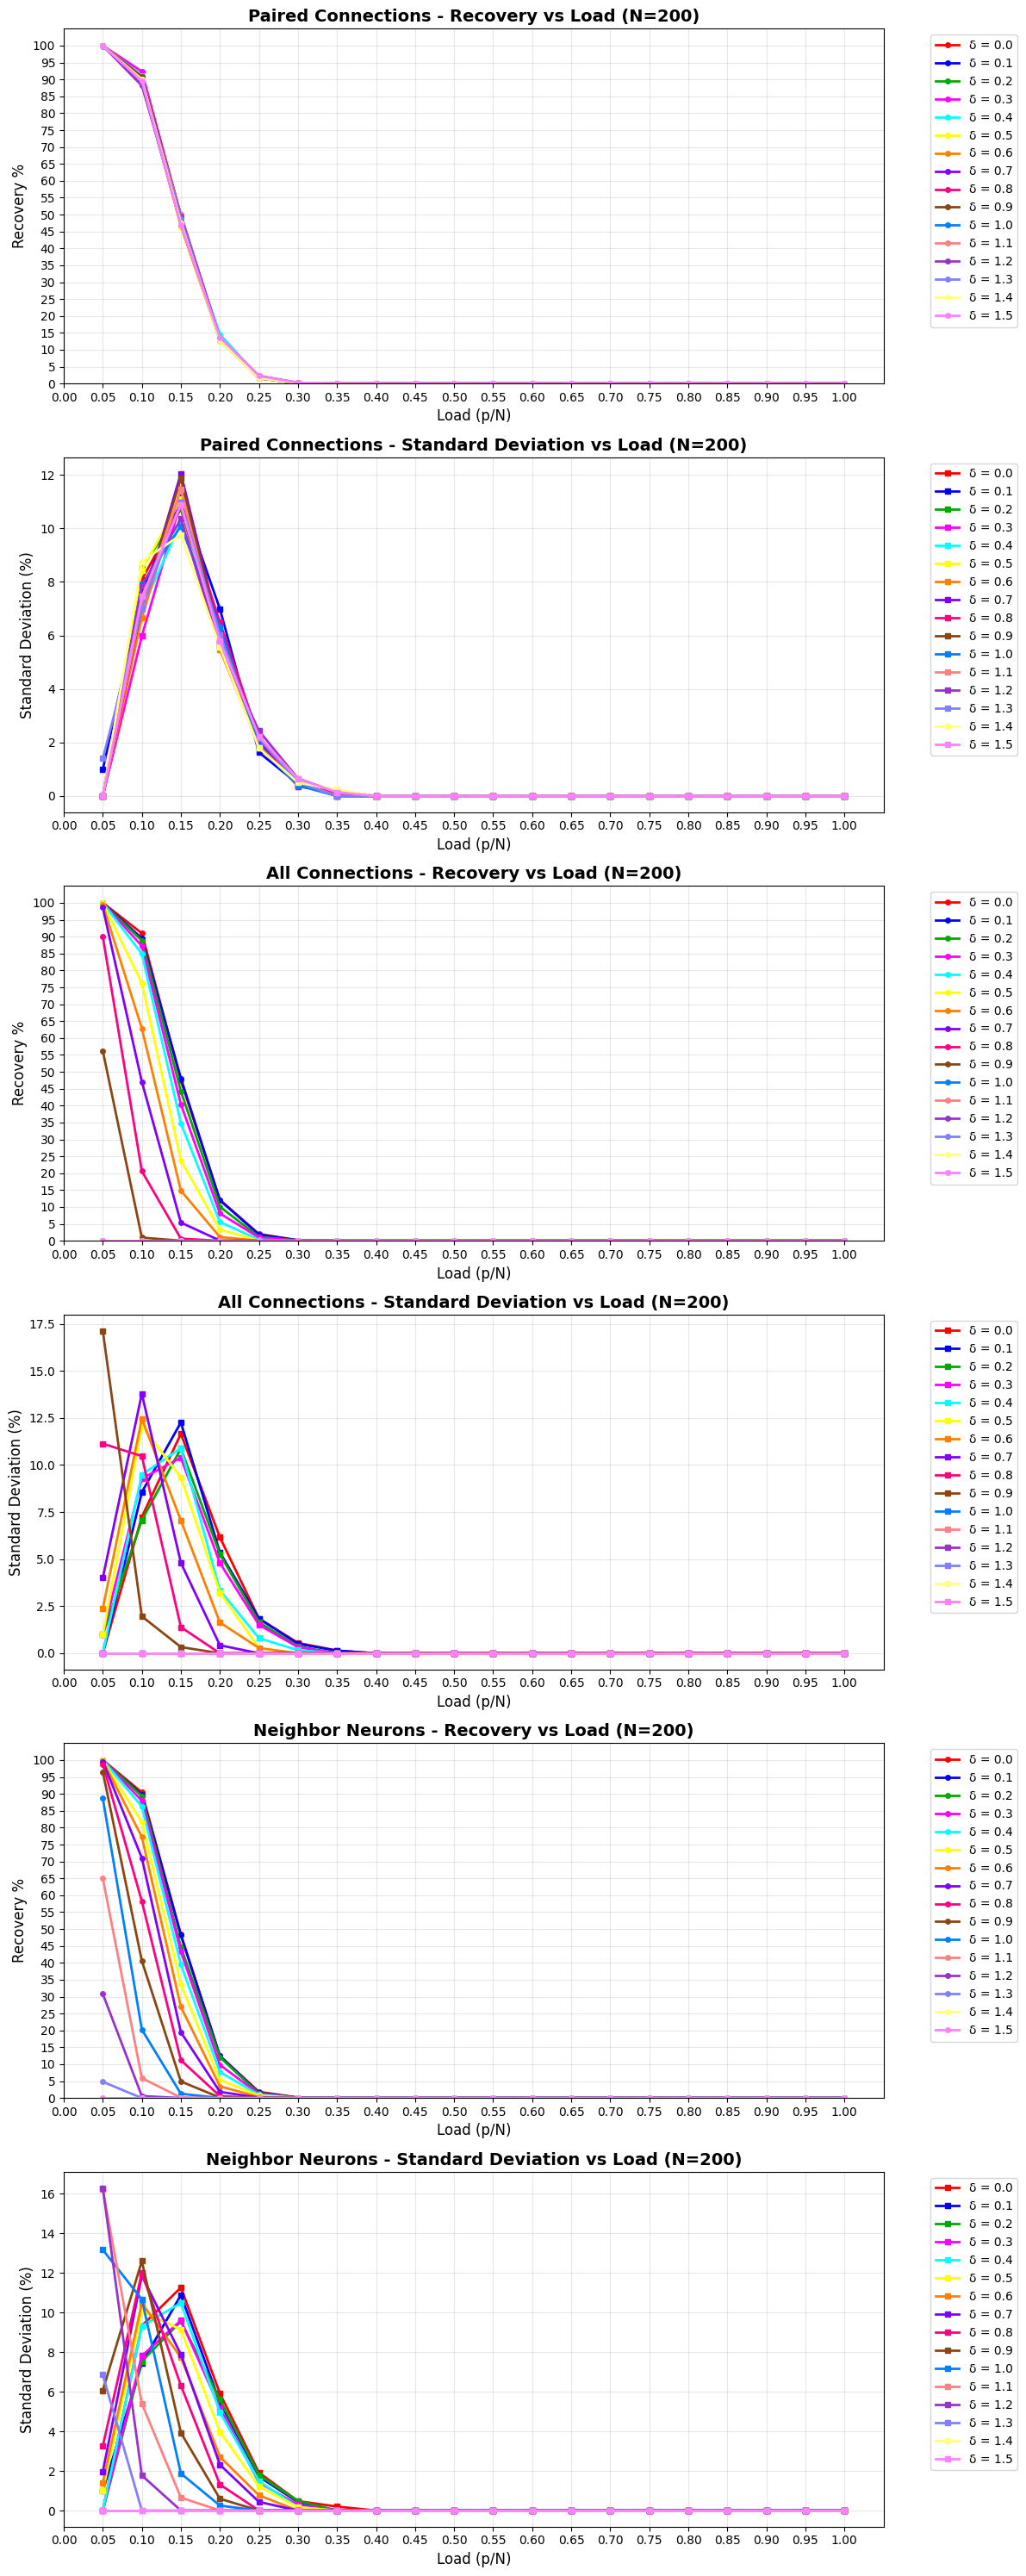


Total analysis time: 31.57 seconds


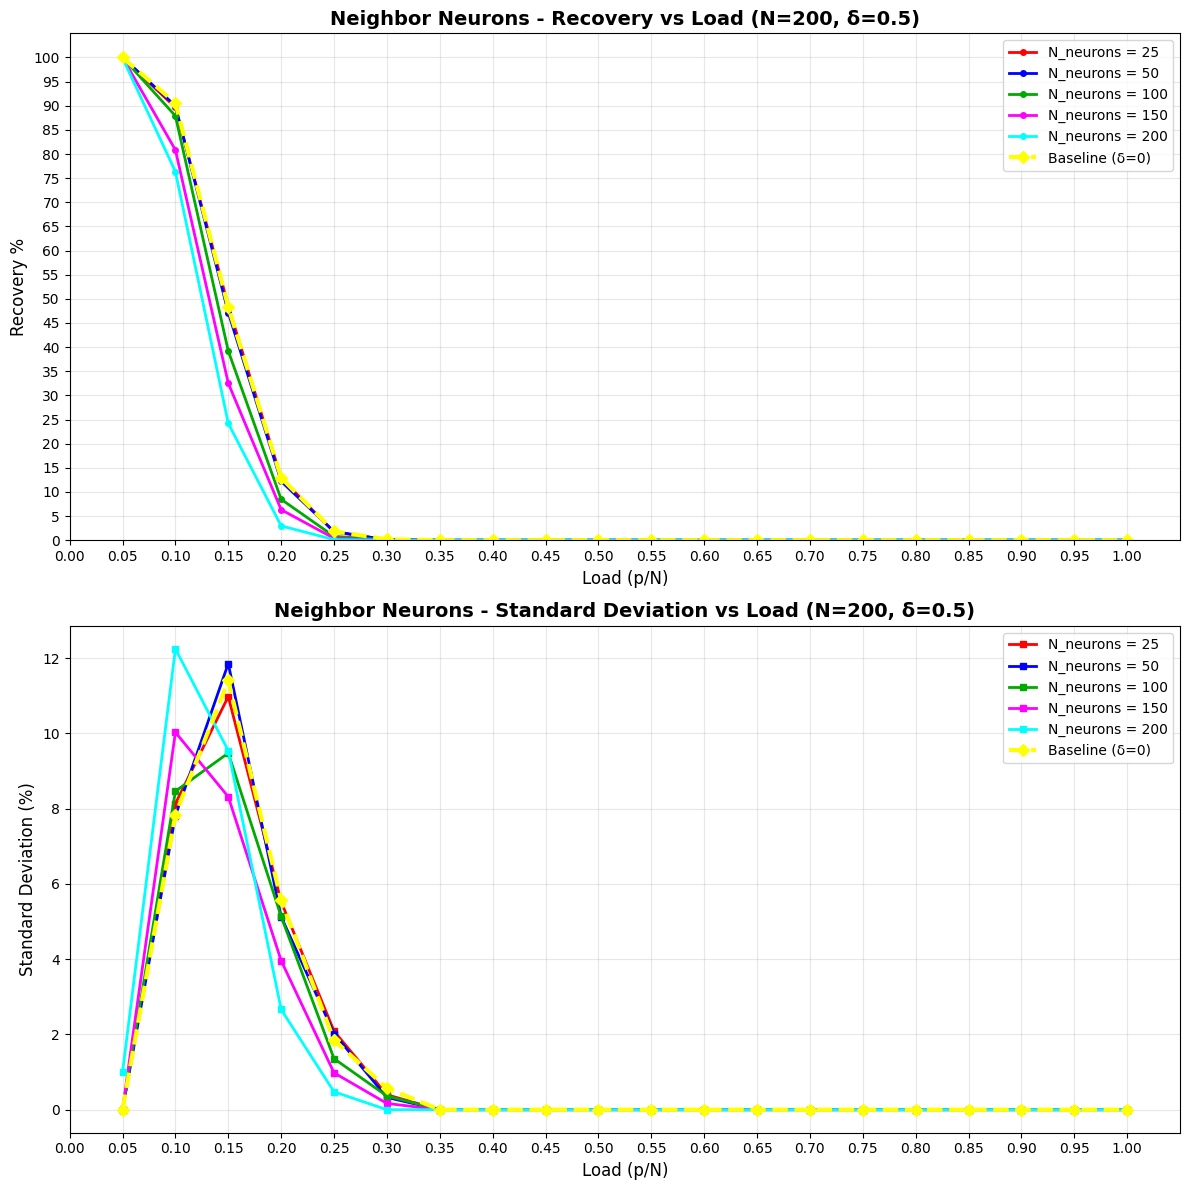

In [ ]:
def get_distinct_colors(n_colors):
    """Generate highly distinct colors for better visualization"""
    # Define a set of highly distinct colors with better green differentiation
    distinct_colors = [
        '#FF0000',  # Red
        '#0000FF',  # Blue
        '#00AA00',  # Dark Green (instead of bright green)
        '#FF00FF',  # Magenta
        '#00FFFF',  # Cyan
        '#FFFF00',  # Yellow
        '#FF8000',  # Orange
        '#8000FF',  # Purple
        '#FF0080',  # Pink
        '#8B4513',  # Brown (replaced lime green)
        '#0080FF',  # Sky Blue
        '#FF8080',  # Light Red
        '#9932CC',  # Dark Orchid Purple (replaced forest green)
        '#8080FF',  # Light Blue
        '#FFFF80',  # Light Yellow
        '#FF80FF',  # Light Magenta
        '#80FFFF',  # Light Cyan
        '#000000',  # Black
        '#808080',  # Gray
        '#400000',  # Dark Red
    ]

    # If we need more colors than predefined, generate them
    if n_colors <= len(distinct_colors):
        return distinct_colors[:n_colors]
    else:
        # Use the predefined colors and add more from a colormap
        additional_colors = plt.cm.tab20(np.linspace(0, 1, n_colors - len(distinct_colors)))
        return distinct_colors + [plt.colors.to_hex(c) for c in additional_colors]

def plot_delta_comparison_graphs():
    """Generate and plot recovery graphs for different delta values with standard deviation"""
    # Parameters
    N = 200
    iterations = 100  # Adjust based on computational budget
    noise_level = 0  # Specific noise level (number of flipped bits)
    max_patterns = 120
    delta_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
    # delta_values = [0.0, 0.3, 0.6, 0.9, 1.2, 1.5]


    N_neurons = int(N / math.sqrt(2))  # ≈ 141  # For neighbor-based asymmetry

    start_time = time.time()

    # Create plots in one column: 6 plots total (3 recovery + 3 std dev)
    fig, axes = plt.subplots(6, 1, figsize=(12, 30))

    asymmetry_types = ['pair', 'all', 'neighbors']
    asymmetry_names = ['Paired Connections', 'All Connections', 'Neighbor Neurons']

    # Get distinct colors for each delta value
    colors = get_distinct_colors(len(delta_values))

    for idx, (asym_type, asym_name) in enumerate(zip(asymmetry_types, asymmetry_names)):
        ax_recovery = axes[idx * 2]      # Recovery percentage plot (0, 2, 4)
        ax_std = axes[idx * 2 + 1]       # Standard deviation plot (1, 3, 5)

        for delta_idx, delta in enumerate(delta_values):
            # Run analysis for this delta value
            load_values, results, std_values = run_recovery_analysis(
                delta, asym_type, f"{asym_name} (delta={delta})",
                iterations, N, max_patterns, noise_level, N_neurons
            )

            # Plot recovery percentage
            ax_recovery.plot(load_values, results, marker='o', label=f'δ = {delta}',
                           linewidth=2, markersize=4, color=colors[delta_idx])

            # Plot standard deviation
            ax_std.plot(load_values, std_values, marker='s', label=f'δ = {delta}',
                       linewidth=2, markersize=4, color=colors[delta_idx])

        # Configure recovery percentage plot
        ax_recovery.set_xlabel('Load (p/N)', fontsize=12)
        ax_recovery.set_ylabel('Recovery %', fontsize=12)
        ax_recovery.set_title(f'{asym_name} - Recovery vs Load (N={N})',
                            fontsize=14, fontweight='bold')
        ax_recovery.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax_recovery.grid(True, alpha=0.3)
        ax_recovery.set_ylim(0, 105)
        ax_recovery.set_xlim(0, 1.05)
        ax_recovery.set_yticks(np.arange(0, 105, 5))  # Y-axis goes up by 5%
        ax_recovery.set_xticks(np.arange(0, 1.01, 0.05))  # X-axis goes up by 0.05

        # Configure standard deviation plot
        ax_std.set_xlabel('Load (p/N)', fontsize=12)
        ax_std.set_ylabel('Standard Deviation (%)', fontsize=12)
        ax_std.set_title(f'{asym_name} - Standard Deviation vs Load (N={N})',
                        fontsize=14, fontweight='bold')
        ax_std.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax_std.grid(True, alpha=0.3)
        ax_std.set_xlim(0, 1.05)
        ax_std.set_xticks(np.arange(0, 1.01, 0.05))  # X-axis goes up by 0.05

    total_time = time.time() - start_time
    print(f"\nTotal analysis time: {total_time:.2f} seconds")

    plt.tight_layout()
    plt.show()

def plot_neighbor_neurons_comparison():
    """Generate comparison plot for different numbers of neighbor neurons with standard deviation"""
    # Parameters
    N = 200
    iterations = 100
    noise_level = 0
    max_patterns = 120
    delta = 0.5  # Fixed delta value

    # Different numbers of neurons to modify
    N_neurons_values = [N//8, N//4, N//2, 3*N//4, N]  # 25, 50, 100, 150, 200 neurons

    start_time = time.time()

    # Create plots for recovery percentage and standard deviation in one column
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Get distinct colors for each N_neurons value
    colors = get_distinct_colors(len(N_neurons_values) + 1)  # +1 for baseline

    for idx, N_neurons in enumerate(N_neurons_values):
        # Run analysis for this number of neurons
        load_values, results, std_values = run_recovery_analysis(
            delta, 'neighbors', f"N_neurons={N_neurons}",
            iterations, N, max_patterns, noise_level, N_neurons
        )

        # Plot recovery percentage
        ax1.plot(load_values, results, marker='o', label=f'N_neurons = {N_neurons}',
                linewidth=2, markersize=4, color=colors[idx])

        # Plot standard deviation
        ax2.plot(load_values, std_values, marker='s', label=f'N_neurons = {N_neurons}',
                linewidth=2, markersize=4, color=colors[idx])

    # Add baseline (no asymmetry)
    load_baseline, results_baseline, std_baseline = run_recovery_analysis(
        0.0, 'single', "Baseline (No Asymmetry)",
        iterations, N, max_patterns, noise_level
    )

    ax1.plot(load_baseline, results_baseline, marker='D', label='Baseline (δ=0)',
            linewidth=3, markersize=6, color=colors[-1], linestyle='--')
    ax2.plot(load_baseline, std_baseline, marker='D', label='Baseline (δ=0)',
            linewidth=3, markersize=6, color=colors[-1], linestyle='--')

    # Configure recovery percentage plot
    ax1.set_xlabel('Load (p/N)', fontsize=12)
    ax1.set_ylabel('Recovery %', fontsize=12)
    ax1.set_title(f'Neighbor Neurons - Recovery vs Load (N={N}, δ={delta})',
                 fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 105)
    ax1.set_xlim(0, 1.05)
    ax1.set_yticks(np.arange(0, 105, 5))  # Y-axis goes up by 5%
    ax1.set_xticks(np.arange(0, 1.01, 0.05))  # X-axis goes up by 0.05

    # Configure standard deviation plot
    ax2.set_xlabel('Load (p/N)', fontsize=12)
    ax2.set_ylabel('Standard Deviation (%)', fontsize=12)
    ax2.set_title(f'Neighbor Neurons - Standard Deviation vs Load (N={N}, δ={delta})',
                 fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 1.05)
    ax2.set_xticks(np.arange(0, 1.01, 0.05))  # X-axis goes up by 0.05

    total_time = time.time() - start_time
    print(f"\nTotal analysis time: {total_time:.2f} seconds")

    plt.tight_layout()
    plt.show()

# Run the analysis
if __name__ == "__main__":
    # Run the delta comparison analysis
    plot_delta_comparison_graphs()

    # Run the neighbor neurons comparison
    plot_neighbor_neurons_comparison()

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()